In [19]:

import sys 
sys.path.append('../src')
import os
import pickle
import argparse
import numpy as np
from collections import deque
import torch.nn.functional as F
import torch
import torch.optim as optim
from tensorboardX import SummaryWriter 

from models.actor import Actor
from models.critic import Critic
from models.discriminator import Discriminator
from GAIL import *

from dialog_environment import DialogEnvironment

device='cuda' # for now

In [22]:

from argparse import Namespace
args = Namespace(load_model=None,
                render=False,
                gamma=.99,
                lamda=.98,
                learning_rate=5e-3,
                l2_rate=0,
                clip_param=.2,
                discrim_update_num=1,
                actor_critic_update_num=100,
                total_sample_size=100,
                batch_size=512,
                suspend_accu_exp=None,# won't stop
                suspend_accu_gen=None,
                max_iter_num=4000,
                seed=0,
                logdir='logs/BCP',
                 hidden_size=512,
                 num_layers=3,
                 seq_len=5,
                 input_size=50
                )

In [ ]:
losses = []
similarities = []
def main():
    
    env = DialogEnvironment()
    experiment_name = args.logdir.split('/')[1] #model name

    torch.manual_seed(args.seed)

    #TODO
    actor = Actor(hidden_size=args.hidden_size,num_layers=args.num_layers,device='cuda',input_size=args.input_size,output_size=args.input_size)
    
    actor.to(device)
    actor.train()

    actor_optim = optim.Adam(actor.parameters(), lr=args.learning_rate)
    # load demonstrations

    writer = SummaryWriter(args.logdir)

    if args.load_model is not None: #TODO
        saved_ckpt_path = os.path.join(os.getcwd(), 'save_model', str(args.load_model))
        ckpt = torch.load(saved_ckpt_path)

        actor.load_state_dict(ckpt['actor'])
 

    
    episodes = 0


    for iter in range(args.max_iter_num):
 

        steps = 0
        scores = []
        states = []
        expert_actions = []
        while steps < args.batch_size: 
            scores = []
            similarity_scores = []
            state, expert_action, raw_state, raw_expert_action = env.reset()

            score = 0
            similarity_score = 0
            state = state[:args.seq_len,:]
            expert_action = expert_action[:args.seq_len,:]
            state = state.to(device)
            expert_action = expert_action.to(device)
            states.append(state)
            expert_actions.append(expert_action)



         #   similarity_score += get_cosine_sim(expert=expert_action,action=action.squeeze(),seq_len=5)
#            print(get_cosine_sim(s1=expert_action,s2=action.squeeze(),seq_len=5),'sim')

            episodes += 1
            steps += 1
           # similarity_scores.append(similarity_score)
        states = torch.stack(states)
        actions_pred , _ = actor(states)
        expert_actions = torch.stack(expert_actions)



      #  similarity_score_avg = np.mean(similarity_scores)
  #      print('{}:: {} episode similarity score is {:.2f}'.format(iter, episodes, similarity_score_avg))

        loss = F.l1_loss(actions_pred,expert_actions,reduce='sum')
        print("Loss:",loss) 
        losses.append(loss.item())
        batch_sim = 0
        for i in range(expert_actions.shape[0]):
            batch_sim += get_cosine_sim(expert=expert_actions[i],action=actions_pred[i].detach(),seq_len=5)
        similarities.append(batch_sim / args.batch_size)
        print(batch_sim / args.batch_size)

        actor_optim.zero_grad()
        loss.backward()
        actor_optim.step() 
        # and this is basically all we need to do

if __name__=="__main__":
    main()





Loss: tensor(0.1459, device='cuda:0', grad_fn=<L1LossBackward>)
0.1014858258051845
Loss: tensor(0.1446, device='cuda:0', grad_fn=<L1LossBackward>)
0.2044568582634838
Loss: tensor(0.1446, device='cuda:0', grad_fn=<L1LossBackward>)
0.20397048700397136
Loss: tensor(0.1391, device='cuda:0', grad_fn=<L1LossBackward>)
0.2938704163279908
Loss: tensor(0.1333, device='cuda:0', grad_fn=<L1LossBackward>)
0.3394873408942658
Loss: tensor(0.1315, device='cuda:0', grad_fn=<L1LossBackward>)
0.3665355759731028
Loss: tensor(0.1289, device='cuda:0', grad_fn=<L1LossBackward>)
0.379356551085948


In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

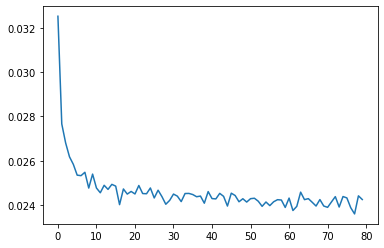

In [17]:
plt.plot(losses)


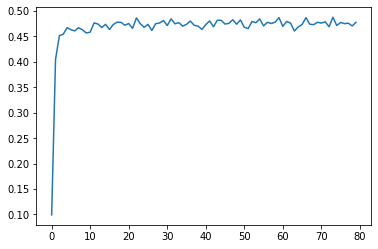

In [18]:
plt.plot(similarities)

In [ ]:
import torch.nn as nn
input1 = torch.randn,100, 128)
input2 = torch.randn(1,100, 128)
cos = nn.CosineSimilarity(dim=1, eps=1e-6)
output = cos(input1, input2)

In [ ]:
output.shape

In [ ]:
actor = Actor(hidden_size=args.hidden_size,num_layers=args.num_layers,device='cuda',input_size=args.input_size,output_size=args.input_size)


In [ ]:
env = DialogEnvironment()


In [ ]:
actor = actor.to(device)

In [ ]:
scores = []
similarity_scores = []
state, expert_action, raw_state, raw_expert_action = env.reset()
score = 0
similarity_score = 0
state = state[:args.seq_len,:]
expert_action = expert_action[:args.seq_len,:]
state = state.to(device)
expert_action = expert_action.to(device)

In [ ]:
mu, std = actor(state.resize(1,args.seq_len,args.input_size)) #TODO: gotta be a better way to resize. 


In [ ]:

def log_prob_density(x, mu, std):
    #TODO: Sanity check a few of these.. 
    log_prob_density = -(x - mu).pow(2) / (2 * std.pow(2)) \
                     - 0.5 * math.log(2 * math.pi)
    return log_prob_density.sum(2, keepdim=True).sum(1, keepdim=True) # I think this fixed it. 


log_prob_density(expert_action, mu, std)

In [ ]:
expert_action - mu

In [ ]:
action = get_action(mu,std)

In [ ]:
mu.shape

In [ ]:
expert_action.shape

In [ ]:
import torch.nn.functional as F

In [ ]:
F.mse_loss(mu,expert_action.unsqueeze(dim=0)) # this won't be needed soon. 

In [ ]:
expert_action.unsqueeze(dim=0).shape

In [ ]:

steps = 0
scores = []
states = []
expert_actions = []
while steps < 16: 
    scores = []
    similarity_scores = []
    state, expert_action, raw_state, raw_expert_action = env.reset()

    score = 0
    similarity_score = 0
    state = state[:args.seq_len,:]
    expert_action = expert_action[:args.seq_len,:]
    #state = state.to(device)
    #expert_action = expert_action.to(device)
    states.append(state)
    expert_actions.append(expert_action)
    
    steps += 1


In [ ]:
states = torch.stack(states).to(device)

In [ ]:
states.shape

In [ ]:
expert_actions = torch.stack(expert_actions).to(device)

In [ ]:
mu, std = actor(states)

In [ ]:
mu.shape

In [ ]:
loss = F.mse_loss(mu,expert_actions)

In [ ]:
logprobs = log_prob_density(expert_action.cpu(),mu.cpu(),std.cpu())

In [ ]:
logprobs.shape

In [ ]:
def log_prob_density(x, mu, std):
    #TODO: Sanity check a few of these.. 
    log_prob_density = -(x - mu).pow(2) / (2 * std.pow(2)) \
                     - 0.5 * math.log(2 * math.pi)
    return log_prob_density.sum(2, keepdim=True)

In [ ]:
logprobs = log_prob_density(expert_action.cpu(),mu.cpu(),std.cpu())
logprobs.shape

In [ ]:
logprobs.shape

In [ ]:
ratio = torch.exp(logprobs - .4*logprobs)
#surrogate_loss = ratio * advants
#entropy = get_entropy(mu, std)

In [ ]:
ratio.shape

In [ ]:
def surrogate_loss(actor, advants, states, old_policy, actions, batch_index):
    """
    The loss for PPO. Re-run through network, recomput policy from states
    and see if this surrogate ratio is better. If it is, use as proximal policy update. It's very close to prior policy, but def better. 
    
    Not sure this actually works though. Should not the new mu and stds be used to draw,
    
        When do we use get_action? Only once in main, I think it should be for all? 
    """
    mu, std = actor(states)
    new_policy = log_prob_density(actions, mu, std)
    old_policy = old_policy[batch_index]

    ratio = torch.exp(new_policy - old_policy)
    surrogate_loss = ratio * advants
    entropy = get_entropy(mu, std)

    return surrogate_loss, ratio, entropy